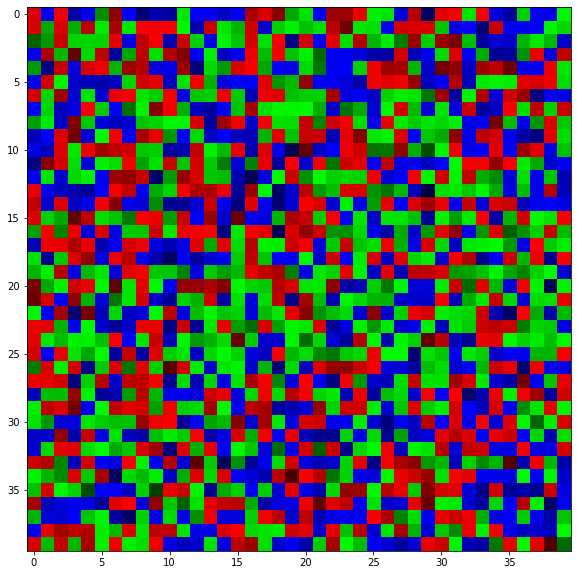

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as an
import copy
%matplotlib inline

#creation of the initial image
operator_dim = 2
image_dim = operator_dim*20
min_color = 50
max_color = 250
random_colored_image = np.array(min_color + (max_color-min_color)*np.random.random((image_dim,image_dim,3)),dtype = 'uint8')


R = random_colored_image[:,:,0] 
G = random_colored_image[:,:,1] 
B = random_colored_image[:,:,2] 

R[R<=G] = 0
G[G<=R] = 0
B[B<=G] = 0
R[R<=B] = 0
G[G<=B] = 0
B[B<=R] = 0




print_colors = False
if print_colors:
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(R,'Reds')
    plt.subplot(1,3,2)
    plt.imshow(G,'Greens')
    plt.subplot(1,3,3)
    plt.imshow(B,'Blues')
    plt.show()



plt.figure(figsize=(10,10))
plt.imshow(random_colored_image)
plt.show()





# save and import if needed
# cv2.imwrite('king_position_weight.jpg', image)
# gray = cv2.imread("king_position_weight.jpg", cv2.IMREAD_GRAYSCALE)

In [2]:
#function to optimize

#the variation of color between neighbours

#division of the image in the 3 colors
def fitness(image):
    
    R = image[:,:,0] 
    G = image[:,:,1] 
    B = image[:,:,2] 
    
    #kernels 
    kernels = []
#forward mean
#     kernels.append(np.array([[-1,1],
#                        [-2,2],
#                        [-1,1]])/4)
#     kernels.append(np.array([[-1,-2,-1],
#                        [1,2,1]])/4)
#central mean
#     kernels.append(np.array([[-1,0,1],
#                        [-2,0,2],
#                        [-1,0,1]])/4)
#     kernels.append(np.array([[-1,-2,-1],
#                        [0,0,0],
#                        [1,2,1]])/4)
#forward
    kernels.append(np.array([[-1,1]]))
    kernels.append(np.array([[-1],
                             [1]]))
    
    def slider(operator,image):
        i = 0
        value = 0
        i_operator,j_operator = operator.shape
        image_x,image_y = image.shape[0:2]
        for i in range(image_x-i_operator+1):
            for j in range(image_y-j_operator+1):
                tmp_part_of_image = R[i:i+i_operator,j:j+j_operator]
                tmp_result = abs(np.sum(tmp_part_of_image*operator))
                value += tmp_result
                tmp_part_of_image = G[i:i+i_operator,j:j+j_operator]
                tmp_result = abs(np.sum(tmp_part_of_image*operator))
                value += tmp_result
                tmp_part_of_image = B[i:i+i_operator,j:j+j_operator]
                tmp_result = abs(np.sum(tmp_part_of_image*operator))
                value += tmp_result
                j+=1
            i+=1
        return value
    fitness_value = 0
    for kernel in kernels:
        fitness_value += slider(kernel,image)
    return fitness_value

In [ ]:
#search for the best image with permutation(base)
max_iterations = 10000
good_value = 10
i = 0
best = fitness(random_colored_image)
while(best>=good_value and i < max_iterations):
    permutation = image_permutation(random_colored_image)
    candidate = fitness(permutation)
    if candidate < best:
        best = candidate
        best_image = permutation
    i+=1
    if not i%(max_iterations/10):
        print(max_iterations/i)
    
    
plt.figure(figsize=(5,5))
plt.imshow(best_image)
plt.show()

print(best)



In [5]:
#utilities
def saturation(value,high,low):
    if value>high:
        return high
    if value<low:
        return low
    return value

In [6]:
#creation of neighbourhood

#permutation
def image_permutation(permutation):
    return np.random.permutation(permutation)

#k-exchange
def k_exchange(k,image_dim):
    movements = set()
    for i in range(k):
        coordinates_to_exchange = np.array(image_dim*np.random.random((2,2)),dtype = int)
        movements.add((coordinates_to_exchange[0,0],coordinates_to_exchange[0,1],coordinates_to_exchange[1,0],coordinates_to_exchange[1,1]))
    return movements    
        
#manhattan distance movement
def manhattan_distance_movement(matrix_dim,lenght_movement=1):
    movements = set()
    for i in range(matrix_dim-lenght_movement):
        for j in range(matrix_dim-lenght_movement):
            for k in range(1,lenght_movement+1):
                movements.add((i,j,i,j+k))
                movements.add((i,j,i+k,j))
    return movements

#exchange of two pixels with difference in fitness(based on operator size(2))            
def exchange(image,coordinates):
    x1,y1,x2,y2 = coordinates
    low = 0
    high = image.shape[0]
    #(3,3) slices
    
    old_fitness = fitness(image[saturation(x1-1,high,low):saturation(x1+2,high,low),saturation(y1-1,high,low):saturation(y1+2,high,low)])+fitness(image[saturation(x2-1,high,low):saturation(x2+2,high,low),saturation(y2-1,high,low):saturation(y2+2,high,low)])
    a = copy.copy(image[x1,y1])
    image[x1,y1] = image[x2,y2]
    image[x2,y2] = a
    new_fitness = fitness(image[saturation(x1-1,high,low):saturation(x1+2,high,low),saturation(y1-1,high,low):saturation(y1+2,high,low)])+fitness(image[saturation(x2-1,high,low):saturation(x2+2,high,low),saturation(y2-1,high,low):saturation(y2+2,high,low)])
    return new_fitness-old_fitness

    
        


In [12]:
#hill climbing for k_exchange
def hill_climbing_k_exchange(max_iterations,good_value,neighbour_dimension,k,image):
    video = []
    i = 0
    stop = False
    best = fitness(image)
    best_image = image
    while(best>=good_value and i < max_iterations and not stop):
        for j in range(neighbour_dimension):
            stop = True
            image = np.copy(best_image)
            moves = k_exchange(k,image_dim)
            dfitness = 0
            for move in moves:
                dfitness += exchange(image,move)    
            candidate = best+dfitness
            i+=1
            if not i%(max_iterations/10):
                print(10-i/max_iterations*10,sep = ' ')
            if candidate < best:
                best = candidate
                best_image = np.copy(image)
                video.append([plt.imshow(best_image,animated = True)])
                stop = False
                break 
    if best < good_value:
        print('better than good value')
    elif i>max_iterations:
        print('max iteration')
    else:
        print('local minimum')
    print('')
    print(best)       

    plt.figure(figsize=(5,5))
    plt.imshow(best_image)
    plt.show()
    return best_image, video

    

In [52]:
#hill climbing for manhattan distance
def hill_climbing_manhattan(max_iterations,good_value,distance,image):
    #video generation
#     fourcc = cv2.VideoWriter_fourcc(*'DIVX')
#     # N.B. we need to specify the correct width and height of the frames otherwise we will not be able to reproduce the video
#     out = cv2.VideoWriter('output.avi', fourcc, 24, (image_dim,image_dim))
    fourcc = cv2.VideoWriter_fourcc(*'FFV1')
    out = cv2.VideoWriter('output.avi', fourcc, 20, (image_dim,image_dim))
    i = 0
    stop = False
    best = fitness(image)
    best_image = image
    moves = manhattan_distance_movement(image.shape[0],distance)
    while(best>=good_value and i < max_iterations and not stop):
        for move in moves:
            stop = True
            image = np.copy(best_image)
            exchange(image,move)
            candidate = fitness(image)
            i+=1
            if not i%(max_iterations/10):
                print(10-i/max_iterations*10,sep = ' ')
            if candidate < best:
                best = candidate
                best_image = np.copy(image)
                out.write(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),)
                stop = False
                break 
        
    out.release()
    if best < good_value:
        print('better than good value')
    elif i>max_iterations:
        print('max iteration')
    else:
        print('local minimum')
    print('')
    print(best)       

    plt.figure(figsize=(5,5))
    plt.imshow(best_image)
    plt.show()
    return best_image


9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
0.0
max iteration

514539


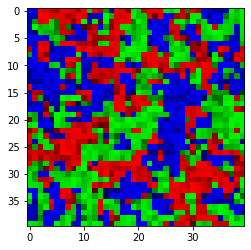

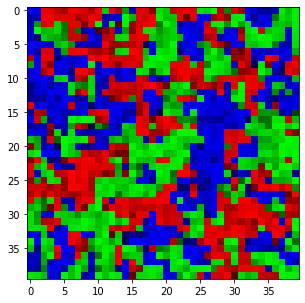

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


ValueError: unknown file extension: .mp4

<Figure size 360x360 with 0 Axes>

In [15]:
max_iterations = 5000
good_value = 100
k = 2
neighbourhood = int(max_iterations/10)
best_image,video = hill_climbing_k_exchange(max_iterations,good_value,neighbourhood,k,random_colored_image)

fig = plt.figure(figsize=(5,5))
anim = an.ArtistAnimation(fig,video)
anim.save('video.mp4')

In [ ]:
max_iterations = 10000
good_value = 100
distance = 2
best_image = hill_climbing_manhattan(max_iterations,good_value,distance,random_colored_image)

In [57]:
play_video('out.avi')

Released Video Resource


In [60]:
cv2.imwrite("random_color_480.png", random_colored_image)
cv2.imwrite("k_exchange_hill_climb_color_480.png", best_image)

True

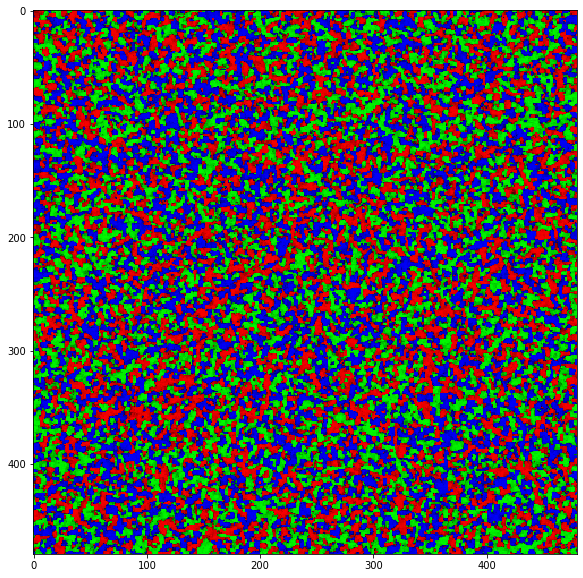

In [59]:
plt.figure(figsize=(10,10))
plt.imshow(best_image)
plt.show()

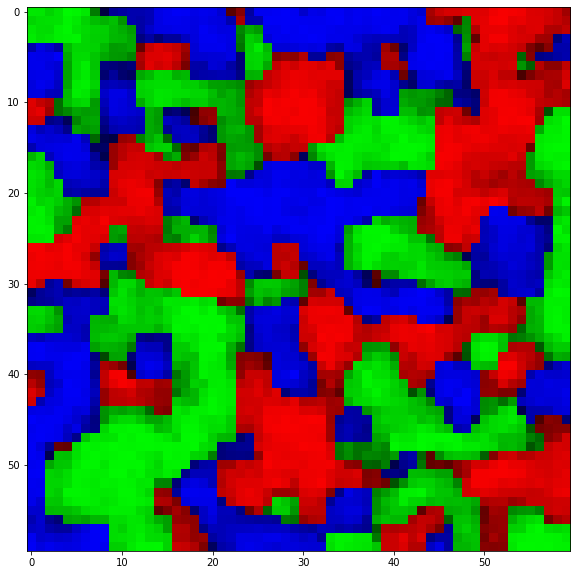

In [47]:
plt.figure(figsize=(10,10))
plt.imshow(best_image)
plt.show()

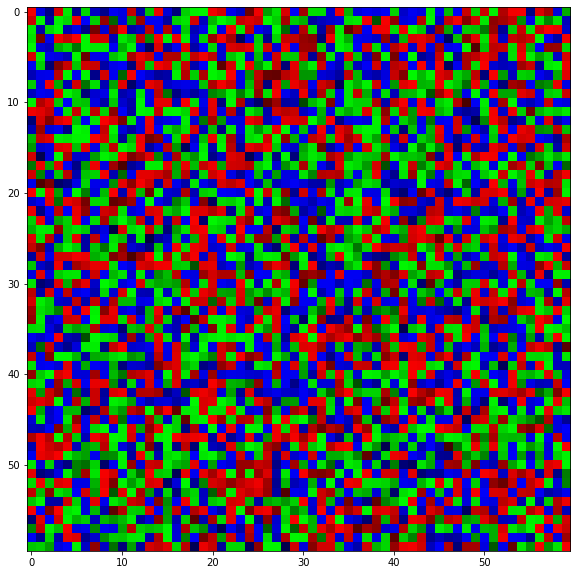

In [49]:
plt.figure(figsize=(10,10))
plt.imshow(random_colored_image)
plt.show()

local minimum

498.5


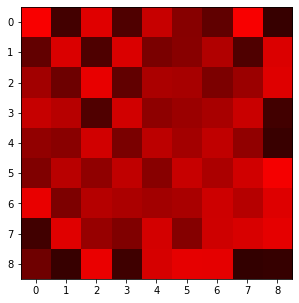

In [154]:
#recursive hill climb
best_image = hill_climbing(max_iterations,good_value,3000,1,best_image)

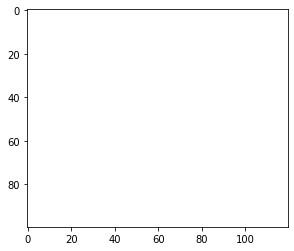

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = plt.imshow(f(x, y), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

plt.show()